In [86]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import graphviz
import pydot
import pandas as pd
from operator import itemgetter
from tqdm import tqdm
from keras import backend as K 
from tensorflow.keras import regularizers
from tensorflow.keras import initializers
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_multilabel_classification
from sklearn.preprocessing import StandardScaler
from tensorflow import keras 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras.metrics import Recall, Accuracy, BinaryAccuracy, Precision
from sklearn.datasets import make_classification

In [103]:
df=pd.read_csv("matrix_ju_debut.csv") #si c'est pas la même df je vous laisse la changer
pd.options.mode.chained_assignment = None  # default='warn'


# je vais d'abord convertir mes classes en nombres
# clean = 0 
# anomaly = 1
# attack = 1

for i in df.index : 
    if df.loc[i,'label'] == "clean":
        df.loc[i,'label'] = 0
    elif df.loc[i,"label"] == "attack":
            df.loc[i,"label"] = 1
    else :
        df.loc[i,"label"] = 1
        

df=df.iloc[:,1:] 



In [104]:
# on transforme en array
array_final = df.to_numpy()

#on mélange les clean et les attack
np.random.shuffle(array_final)

#on sépare le label des autres feature 
X=array_final[:,1:]
y=array_final[:,0]

X = np.asarray(X).astype('float32')
y = np.asarray(y).astype('float32')

#cela servira de vérification ; on les laisse de côté
X_apart=X[:100]
Y_apart=y[:100]

#séparer en set entrainement et test 
X_train=X[100:700]
Y_train=y[100:700]
X_test=X[700:]
Y_test=y[700:]



In [105]:
ecart=np.std(X_train, axis=0) # la liste des écarts types par colonne
moyenne=np.mean(X_train,axis=0) # la liste des moyennes par colonne


X_apart=X_apart-moyenne
X_apart=X_apart/ecart
X_train= X_train-moyenne
X_test=X_test-moyenne
X_test=X_test/ecart
X_train=X_train/ecart

In [106]:
nb_neurones = 11
nb_epoch = 30
lr = 0.0001
batch_size = 1
vs=0.1
weight = 5
class_weight = {0: 1.,
             1: weight}
mon_optimizer = keras.optimizers.Adam(lr)

5/5 [==============================] - 0s 3ms/step - loss: 0.4934 - binary_accuracy: 0.7750 - precision: 0.3469 - recall: 0.8095
Accuracy: 77.50
Precision: 34.69
Recall: 80.95
Loss: 49.34


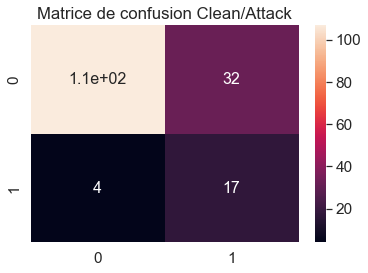

In [108]:
K.clear_session()
inputs = keras.Input(shape=(35,))
dense1=layers.Dense(30, activation="selu",
    kernel_initializer=initializers.RandomNormal(stddev=0.01),
                                    bias_initializer=initializers.Zeros())
x=dense1(inputs)
dense2 = layers.Dense(nb_neurones, activation="selu",
                                     kernel_regularizer=regularizers.l1(l1=1e-5),
                                        bias_regularizer=regularizers.l1(1e-4),
                                    activity_regularizer=regularizers.l1(1e-5),
                                    bias_initializer=initializers.Zeros())
x=dense2(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model=keras.Model(inputs=inputs, outputs=outputs, name="first_model")
model.compile(loss='binary_crossentropy', 
                                      optimizer=mon_optimizer, 
                                      metrics=[BinaryAccuracy(),Precision() , Recall()]
                                         )
history = model.fit(X_train, 
                                    Y_train, 
                                    validation_split=vs, 
                                    epochs=nb_epoch, 
                                    batch_size=batch_size,
                                    class_weight = class_weight,
                                    verbose = 0
                                        )

                                    # evaluate the keras model

loss, accuracy, precision, recall = model.evaluate(X_test, Y_test) 
print('Accuracy: %.2f' % (accuracy*100))
print('Precision: %.2f' % (precision*100))
print('Recall: %.2f' % (recall*100))
print('Loss: %.2f' % (loss*100))

cm=confusion_matrix(Y_test,model.predict(X_test)>.5)

# Normaliser la matrice
cmn = cm.astype('float') 

df_cm = pd.DataFrame(cm, range(2), range(2))

sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16})

plt.title("Matrice de confusion Clean/Attack")

plt.show()